In [17]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def ensure_positions_outside_obstacles(positions, obstacles, radii, buffer_distance=0.1):
    for i in range(len(positions)):
        valid_position = False
        while not valid_position:
            valid_position = True
            for j in range(len(obstacles)):
                if np.linalg.norm(positions[i] - obstacles[j]) < radii[j] + buffer_distance:
                    angle = np.random.rand() * 2 * np.pi
                    positions[i] = obstacles[j] + (radii[j] + buffer_distance) * np.array([np.cos(angle), np.sin(angle)])
                    valid_position = False
                    break
    return positions

def multi_agent_rhc_free_energy(initial_states, reference_states, obstacles, radii, prediction_horizon=10, time_step=0.1):
    num_agents = initial_states.shape[0]
    state_dim = initial_states.shape[1]
    control_dim = state_dim  # Assuming control dimension matches state dimension for simplicity

    def system_dynamics(x, u):
        return x + u * time_step
    
    def calculate_goal_cost(x, x_ref, u, u_ref):
        distance_error = ca.sumsqr(x - x_ref)
        control_effort = ca.sumsqr(u - u_ref)
        return distance_error + 0.01 * control_effort  # 0.01 is a weighting factor
    
    opti = ca.Opti()
    X = [[opti.variable(state_dim) for _ in range(prediction_horizon + 1)] for _ in range(num_agents)]
    U = [[opti.variable(state_dim) for _ in range(prediction_horizon)] for _ in range(num_agents)]

    X_ref = opti.parameter(state_dim, num_agents)
    U_ref = np.zeros((state_dim, num_agents))

    total_cost = 0
    max_velocity = 1
    min_distance = 0.2

    for i in range(num_agents):
        opti.subject_to(X[i][0] == initial_states[i])
        for k in range(prediction_horizon):
            opti.subject_to(X[i][k + 1] == system_dynamics(X[i][k], U[i][k]))
            prediction_error = calculate_goal_cost(X[i][k], X_ref[:, i], U[i][k], U_ref[:, i])
            total_cost += prediction_error
            for dim in range(state_dim):
                opti.subject_to(U[i][k][dim] <= max_velocity)
                opti.subject_to(U[i][k][dim] >= -max_velocity)

    for k in range(prediction_horizon):
        for i in range(num_agents):
            for j in range(i + 1, num_agents):
                distance = ca.sqrt(ca.sumsqr(X[i][k] - X[j][k]))
                collision_avoidance_cost = ca.fmax(0, min_distance - distance) ** 2
                total_cost += 1e6 * collision_avoidance_cost  # High penalty for collisions
                opti.subject_to(distance >= min_distance)
            # Obstacle avoidance constraints
            for o in range(len(obstacles)):
                distance_to_obstacle = ca.sqrt(ca.sumsqr(X[i][k] - obstacles[o]))
                opti.subject_to(distance_to_obstacle >= radii[o] + min_distance)

    opti.minimize(total_cost)

    # Initialize variables
    for i in range(num_agents):
        for k in range(prediction_horizon + 1):
            opti.set_initial(X[i][k], initial_states[i])
        for k in range(prediction_horizon):
            opti.set_initial(U[i][k], 0)

    p_opts = {"verbose": False}
    s_opts = {"max_iter": 10000, "print_level": 0}  # Reduced maximum iterations for faster convergence
    opti.solver('ipopt', p_opts, s_opts)
    return opti, X, X_ref, U, num_agents, state_dim, control_dim, prediction_horizon

def solve_opti(opti, X, X_ref, U, reference_states, num_agents, state_dim, control_dim, prediction_horizon):

    opti.set_value(X_ref, reference_states.T)
    
    try:
        sol = opti.solve()
    except RuntimeError as e:
        print(f"Solver failed: {e}")
        return None, None

    optimal_u = np.zeros((num_agents, control_dim))
    for i in range(num_agents):
        for dim in range(control_dim):
            optimal_u[i][dim] = sol.value(U[i][0][dim])

    trajectories = np.zeros((state_dim, prediction_horizon + 1, num_agents))
    for i in range(num_agents):
        for k in range(prediction_horizon + 1):
            for dim in range(state_dim):
                trajectories[dim, k, i] = sol.value(X[i][k][dim])

    return optimal_u, trajectories

def plot_trajectories(initial_states, reference_states, optimal_control_inputs, trajectories, obstacles, radii, prediction_horizon, time_step):
    num_agents = initial_states.shape[0]

    fig, ax = plt.subplots()
    for i in range(num_agents):
        ax.plot(trajectories[0, :, i], trajectories[1, :, i], label=f'Agent {i+1} Trajectory')
        ax.scatter(initial_states[i, 0], initial_states[i, 1], c='blue', marker='o', label=f'Agent {i+1} Start' if i == 0 else "")
        ax.scatter(reference_states[i, 0], reference_states[i, 1], c='red', marker='x', label=f'Agent {i+1} Goal' if i == 0 else "")

    # Plot obstacles
    for j, obs in enumerate(obstacles):
        circle = plt.Circle((obs[0], obs[1]), radii[j], color='k', fill=False)
        ax.add_patch(circle)

    ax.legend()
    ax.set_title('Trajectories of Agents')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    plt.grid(True)
    plt.show()

def run_simulations(num_simulations=10, env_size=15, num_agents=2, num_obstacles=5, prediction_horizon=10, time_step=0.1):
    data = []

    for seed in range(num_simulations):
        np.random.seed(seed)

        initial_states = np.random.rand(num_agents, 2) * env_size
        reference_states = np.random.rand(num_agents, 2) * env_size
        obstacles = np.random.rand(num_obstacles, 2) * env_size
        radii = np.random.rand(num_obstacles) * 2  # Random radii between 0 and 2

        # Ensure initial positions and goals are outside obstacles
        initial_states = ensure_positions_outside_obstacles(initial_states, obstacles, radii)
        reference_states = ensure_positions_outside_obstacles(reference_states, obstacles, radii)

        current_states = initial_states.copy()
        timestep = 0

        while not np.allclose(current_states, reference_states, atol=0.5):
            opti, X, X_ref, U_ref, num_agents, state_dim, control_dim, prediction_horizon = multi_agent_rhc_free_energy(
                current_states, reference_states, obstacles, radii, prediction_horizon, time_step)

            optimal_control_inputs, trajectories = solve_opti(opti, X, X_ref, U_ref, reference_states, num_agents, state_dim, control_dim, prediction_horizon)

            if trajectories is None:
                break

            # Apply the first control action and update the current states
            for i in range(num_agents):
                current_states[i] += optimal_control_inputs[i] * time_step

            data.append({
                'seed': seed,
                'timestep': timestep,
                'all_control_actions': optimal_control_inputs.tolist(),
                'agent1_x': optimal_control_inputs[0][0],
                'agent1_y': optimal_control_inputs[0][1],
                'agent2_x': optimal_control_inputs[1][0],
                'agent2_y': optimal_control_inputs[1][1],
                'agent1_goal_x': reference_states[0][0],
                'agent1_goal_y': reference_states[0][1],
                'agent2_goal_x': reference_states[1][0],
                'agent2_goal_y': reference_states[1][1],
                'obstacle_positions': obstacles.tolist(),
                'obstacle_radii': radii.tolist(),
                'agent_positions': current_states.tolist(),
                'agent1_x_pos': current_states[0][0],
                'agent1_y_pos': current_states[0][1],
                'agent2_x_pos': current_states[1][0],
                'agent2_y_pos': current_states[1][1],
                'horizon': prediction_horizon,
                'time_step': time_step,
                'environment_size': env_size,
                'initial_positions': initial_states.tolist(),
                'reference_positions': reference_states.tolist()
            })

            timestep += 1

    return pd.DataFrame(data)

# Run the simulations and collect data
num_simulations = 1
env_size = 10
num_agents = 2
num_obstacles = 5
prediction_horizon = 10
time_step = 0.3

simulation_data = run_simulations(num_simulations, env_size, num_agents, num_obstacles, prediction_horizon, time_step)

# Save data to CSV
simulation_data.to_csv('simulation_data.csv', index=False)

# Example usage of plotting for the last simulation
last_simulation_index = simulation_data['seed'].max()
last_simulation_data = simulation_data[simulation_data['seed'] == last_simulation_index]

initial_states = np.array(last_simulation_data.iloc[0]['initial_positions'])
reference_states = np.array(last_simulation_data.iloc[0]['reference_positions'])
obstacles = np.array(last_simulation_data.iloc[0]['obstacle_positions'])
radii = np.random.rand(num_obstacles) * 2  # Example obstacle radii

trajectories = np.array([data['agent_positions'] for data in last_simulation_data.itertuples()]).reshape(-1, num_agents, 2).transpose(1, 0, 2)

plot_trajectories(initial_states, reference_states, [], trajectories, obstacles, radii, prediction_horizon, time_step)


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 35.71us)   1.21ms ( 43.07us)        28
       nlp_g  |   3.00ms (107.14us)   2.15ms ( 76.82us)        28
  nlp_grad_f  |   2.00ms (222.22us) 455.00us ( 50.56us)         9
  nlp_hess_l  |   7.00ms (368.42us)   8.41ms (442.58us)        19
   nlp_jac_g  |   4.00ms (160.00us)   6.14ms (245.80us)        25
       total  | 153.00ms (153.00ms) 152.76ms (152.76ms)         1
Solver failed: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'


KeyError: 'seed'

No constraints given.
New best for swarm at iteration 1: [ 0.09644212  1.          0.2799168   0.64485772  0.58798478  0.50190514
  0.12883881 -0.06778241  0.24687845 -0.11495545  0.35347228  0.71927796
 -0.93320438  0.18690119  1.         -0.63861267  0.00128253 -1.
  1.          0.73116548 -0.8450695   0.31808976 -0.01824364 -0.95545717
  0.12089293  0.18102212  1.          0.26376294 -1.         -1.
  0.25152401  1.         -0.69000696 -0.00842909 -1.         -0.79612761
  0.59475537 -0.36140427  0.90589075 -0.38287229] 13.553272405932296
Best after iteration 1: [ 0.09644212  1.          0.2799168   0.64485772  0.58798478  0.50190514
  0.12883881 -0.06778241  0.24687845 -0.11495545  0.35347228  0.71927796
 -0.93320438  0.18690119  1.         -0.63861267  0.00128253 -1.
  1.          0.73116548 -0.8450695   0.31808976 -0.01824364 -0.95545717
  0.12089293  0.18102212  1.          0.26376294 -1.         -1.
  0.25152401  1.         -0.69000696 -0.00842909 -1.         -0.79612761
  0.59

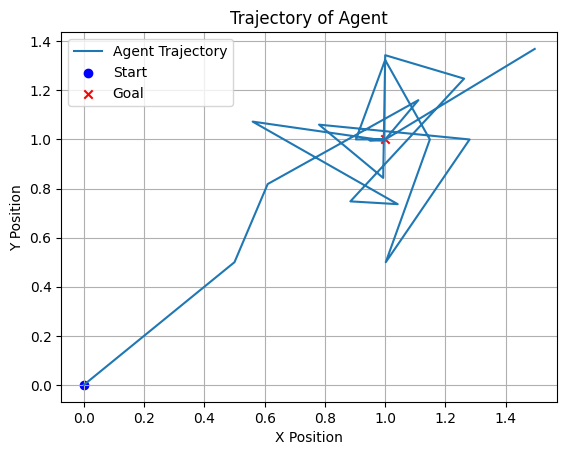

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso

def system_dynamics(x, u, time_step):
    return x + u * time_step

def nonlinear_nonsmooth_cost(X, X_ref):
    # Example nonsmooth cost: L1 norm of differences + a nonsmooth function of the state
    return np.sum(np.abs(X - X_ref))# + np.sum(np.abs(np.sin(X)))

def total_cost(u_flat, initial_state, reference_state, prediction_horizon, time_step):
    state_dim = initial_state.shape[0]
    control_dim = state_dim
    U = u_flat.reshape((prediction_horizon, control_dim))

    X = np.zeros((prediction_horizon + 1, state_dim))
    X[0] = initial_state

    cost = 0
    for k in range(prediction_horizon):
        X[k + 1] = system_dynamics(X[k], U[k], time_step)
        cost += nonlinear_nonsmooth_cost(X[k], reference_state)

    return cost

def multi_agent_rhc_pso(initial_state, reference_state, prediction_horizon=10, time_step=0.1):
    state_dim = initial_state.shape[0]
    control_dim = state_dim

    lower_bounds = -np.ones(prediction_horizon * control_dim)  # Control bounds
    upper_bounds = np.ones(prediction_horizon * control_dim)  # Control bounds

    # PSO optimization with enhanced parameters
    optimal_u_flat, optimal_cost = pso(
        total_cost,
        lb=lower_bounds,
        ub=upper_bounds,
        args=(initial_state, reference_state, prediction_horizon, time_step),
        swarmsize=100,  # Increased swarm size
        maxiter=200,  # Increased iterations
        omega=0.5,  # Inertia weight
        phip=0.8,  # Cognitive coefficient
        phig=0.8,  # Social coefficient
        debug=True  # Enable debugging output
    )

    optimal_u = optimal_u_flat.reshape((prediction_horizon, control_dim))

    # Compute the optimal trajectory
    X = np.zeros((prediction_horizon + 1, state_dim))
    X[0] = initial_state
    for k in range(prediction_horizon):
        X[k + 1] = system_dynamics(X[k], optimal_u[k], time_step)

    return optimal_u, X

def plot_trajectory(initial_state, reference_state, optimal_control_inputs, trajectory, prediction_horizon, time_step):
    plt.plot(trajectory[:, 0], trajectory[:, 1], label='Agent Trajectory')
    plt.scatter(initial_state[0], initial_state[1], c='blue', marker='o', label='Start')
    plt.scatter(reference_state[0], reference_state[1], c='red', marker='x', label='Goal')

    plt.legend()
    plt.title('Trajectory of Agent')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.show()

# Example usage:
initial_state = np.array([0, 0])  # Example initial state for an agent in 2D
reference_state = np.array([1, 1])  # Example reference state for an agent in 2D
prediction_horizon = 20
time_step = 0.5

optimal_control_inputs, trajectory = multi_agent_rhc_pso(initial_state, reference_state, prediction_horizon, time_step)

plot_trajectory(initial_state, reference_state, optimal_control_inputs, trajectory, prediction_horizon, time_step)
